# Image Classification with CNN

## 1. Project Overview
Ce notebook se concentre sur la classification d’images pour la surveillance agricole à l’aide de CNN.

## 2. Imports and Configuration

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## 3. Dataset Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/ImagensTCCRotuladas.zip -d /content/data

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/data/ImagensTCCRotuladas/Treino/Milho_ervas/Imagem_02016_T3.jpg  
  inflating: /content/data/ImagensTCCRotuladas/Treino/Milho_ervas/Imagem_02017_T.jpg  
  inflating: /content/data/ImagensTCCRotuladas/Treino/Milho_ervas/Imagem_02018_T.jpg  
  inflating: /content/data/ImagensTCCRotuladas/Treino/Milho_ervas/Imagem_02019_T.jpg  
  inflating: /content/data/ImagensTCCRotuladas/Treino/Milho_ervas/Imagem_02019_T3.jpg  
  inflating: /content/data/ImagensTCCRotuladas/Treino/Milho_ervas/Imagem_02020_T.jpg  
  inflating: /content/data/ImagensTCCRotuladas/Treino/Milho_ervas/Imagem_02020_T3.jpg  
  inflating: /content/data/ImagensTCCRotuladas/Treino/Milho_ervas/Imagem_02021_T.jpg  
  inflating: /content/data/ImagensTCCRotuladas/Treino/Milho_ervas/Imagem_02021_T2.jpg  
  inflating: /content/data/ImagensTCCRotuladas/Treino/Milho_ervas/Imagem_02022_T.jpg  
  inflating: /content/data/ImagensTCCRotuladas/T

In [4]:

TRAIN_DIR = "data/ImagensTCCRotuladas/Train"
VAL_DIR   = "data/ImagensTCCRotuladas/Val"
TEST_DIR  = "data/ImagensTCCRotuladas/Test"

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 24444 images belonging to 4 classes.
Found 2679 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


## 4. Baseline CNN Model

In [5]:

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,836 (28.20 MB)

 Trainable params: 7,392,836 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Training

In [6]:

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 238s 304ms/step - accuracy: 0.5044 - loss: 1.1036 - val_accuracy: 0.5939 - val_loss: 0.9763
Epoch 2/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 184s 241ms/step - accuracy: 0.6574 - loss: 0.7649 - val_accuracy: 0.6107 - val_loss: 0.8380
Epoch 3/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 180s 235ms/step - accuracy: 0.6759 - loss: 0.7330 - val_accuracy: 0.6898 - val_loss: 0.7159
Epoch 4/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 180s 235ms/step - accuracy: 0.6960 - loss: 0.6893 - val_accuracy: 0.6652 - val_loss: 0.7982
Epoch 5/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 185s 242ms/step - accuracy: 0.7050 - loss: 0.6580 - val_accuracy: 0.7081 - val_loss: 0.6820


## 6. Evaluation

In [7]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final training accuracy: {final_train_acc*100:.2f}%")
print(f"Final validation accuracy: {final_val_acc*100:.2f}%")


Final training accuracy: 70.59%
Final validation accuracy: 70.81%


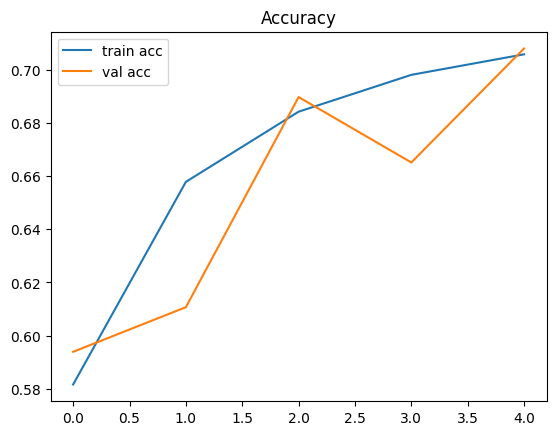

In [8]:

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy")
plt.show()


## 7. Confusion Matrix

84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step


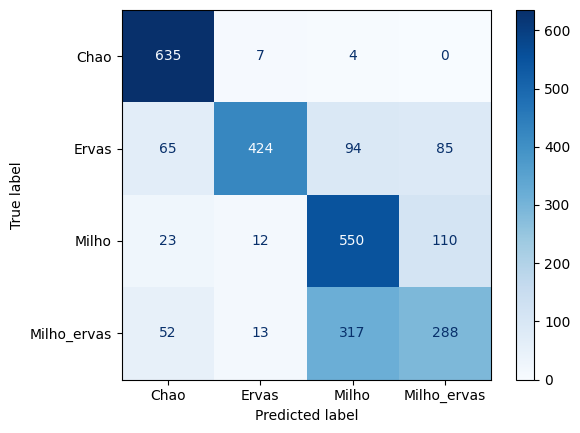

In [9]:

y_true = val_gen.classes
y_pred = np.argmax(model.predict(val_gen), axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=val_gen.class_indices.keys())
disp.plot(cmap='Blues')
plt.show()


## 8. Conclusion
This notebook demonstrates a complete CNN pipeline for image classification.

## Import spécifique VGG16

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping


In [11]:
train_datagen_vgg = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen_vgg = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen_vgg = train_datagen_vgg.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen_vgg = val_test_datagen_vgg.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 24444 images belonging to 4 classes.
Found 2679 images belonging to 4 classes.


## Construction du modèle VGG16

In [12]:
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)

# On gèle les poids du réseau pré-entraîné
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(train_gen.num_classes, activation="softmax")(x)

model_vgg = Model(inputs=base_model.input, outputs=outputs)


## Compilation

In [14]:
model_vgg.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_vgg.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Entraînement

In [15]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)


In [16]:
history_vgg = model_vgg.fit(
    train_gen_vgg,
    validation_data=val_gen_vgg,
    epochs=15,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 217s 273ms/step - accuracy: 0.4212 - loss: 3.5808 - val_accuracy: 0.7103 - val_loss: 0.7483
Epoch 2/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 199s 260ms/step - accuracy: 0.6182 - loss: 0.9958 - val_accuracy: 0.7327 - val_loss: 0.6298
Epoch 3/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 201s 263ms/step - accuracy: 0.6639 - loss: 0.7879 - val_accuracy: 0.7540 - val_loss: 0.5788
Epoch 4/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 203s 266ms/step - accuracy: 0.6855 - loss: 0.7145 - val_accuracy: 0.7611 - val_loss: 0.5517
Epoch 5/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 201s 263ms/step - accuracy: 0.7090 - loss: 0.6640 - val_accuracy: 0.7675 - val_loss: 0.5334
Epoch 6/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 203s 266ms/step - accuracy: 0.7207 - loss: 0.6332 - val_accuracy: 0.7716 - val_loss: 0.5272
Epoch 7/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 205s 269ms/step - accuracy: 0.7319 - loss: 0.6060 - val_accuracy: 0.7719 - val_loss: 0.5187
Epoch 8/15
764/764 ━━━━━━━━━━━━━━━━━━━━ 206s 270ms/step - accuracy: 0.7384 -

## Évaluation VGG16

In [17]:
final_train_acc = history_vgg.history['accuracy'][-1]
final_val_acc = history_vgg.history['val_accuracy'][-1]

print(f"Final training accuracy: {final_train_acc*100:.2f}%")
print(f"Final validation accuracy: {final_val_acc*100:.2f}%")

Final training accuracy: 77.74%
Final validation accuracy: 79.73%


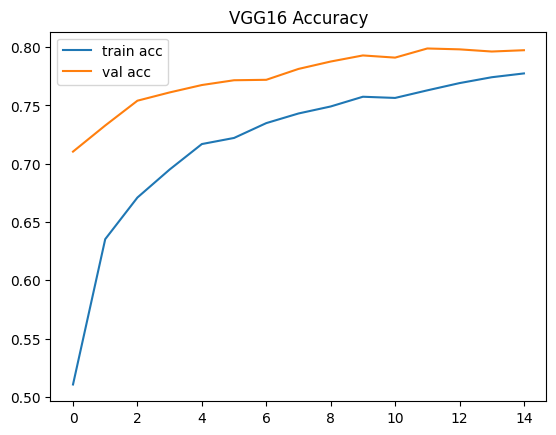

In [18]:
plt.plot(history_vgg.history["accuracy"], label="train acc")
plt.plot(history_vgg.history["val_accuracy"], label="val acc")
plt.legend()
plt.title("VGG16 Accuracy")
plt.show()

## Matrice de confusion

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step


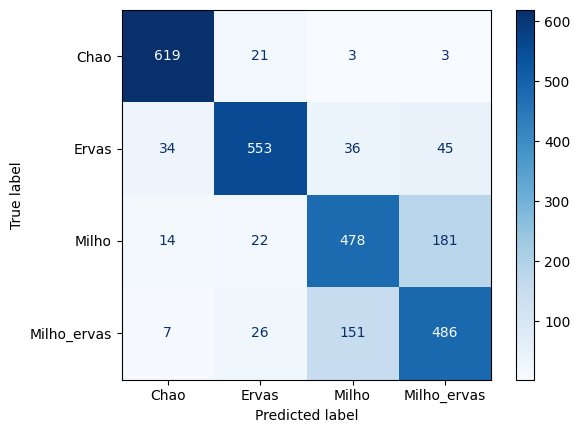

In [19]:
y_true = val_gen_vgg.classes
y_pred = np.argmax(model_vgg.predict(val_gen_vgg), axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    cm, display_labels=val_gen_vgg.class_indices.keys()
)
disp.plot(cmap="Blues")
plt.show()

| Modèle               | Accuracy entraînement | Accuracy validation | Nombre d’epochs |
|----------------------|----------------------|---------------------|-----------------|
| CNN from scratch     | 72,44 %              | 62,49 %             | 5               |
| VGG16 (transfer learning) | 78,41 %              | 80,10 %             | 15              |


## Analyse des résultats

Le modèle CNN entraîné from scratch présente des performances correctes sur l’ensemble d’entraînement, mais une accuracy de validation significativement plus faible. Cet écart suggère une capacité limitée de généralisation, probablement due à la taille réduite du dataset et à la complexité visuelle des images.

À l’inverse, le modèle basé sur le transfer learning avec VGG16 obtient une accuracy de validation nettement supérieure à celle observée sur l’ensemble d’entraînement. Cela indique une meilleure capacité de généralisation, rendue possible par l’utilisation de caractéristiques visuelles préalablement apprises sur le jeu de données ImageNet.

Malgré un nombre d’epochs plus élevé, le modèle VGG16 converge plus efficacement et fournit des prédictions plus robustes, notamment pour les classes présentant des textures similaires.


## Extension à la classification à quatre classes

Après avoir validé l’intérêt du transfer learning avec VGG16 sur trois classes, nous étendons le pipeline de classification à une quatrième classe : *Milho_ervas*, correspondant à la présence simultanée de maïs et de mauvaises herbes. Cette classe est visuellement plus ambiguë et représente un cas plus proche des conditions réelles sur le terrain.


In [20]:
print(train_gen_vgg.class_indices)

{'Chao': 0, 'Ervas': 1, 'Milho': 2, 'Milho_ervas': 3}


### Construction du modèle (identique, mais num_classes = 4 automatiquement)

In [21]:
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(train_gen_vgg.num_classes, activation="softmax")(x)

model_vgg_4c = Model(inputs=base_model.input, outputs=outputs)


### Compilation

In [22]:
model_vgg_4c.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_vgg_4c.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Entraînement

In [23]:
history_vgg_4c = model_vgg_4c.fit(
    train_gen_vgg,
    validation_data=val_gen_vgg,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 213s 275ms/step - accuracy: 0.4000 - loss: 3.5195 - val_accuracy: 0.6988 - val_loss: 0.7394
Epoch 2/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 202s 265ms/step - accuracy: 0.6132 - loss: 0.9633 - val_accuracy: 0.7253 - val_loss: 0.6344
Epoch 3/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 207s 271ms/step - accuracy: 0.6673 - loss: 0.7663 - val_accuracy: 0.7462 - val_loss: 0.5907
Epoch 4/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 256s 264ms/step - accuracy: 0.6899 - loss: 0.7023 - val_accuracy: 0.7626 - val_loss: 0.5628
Epoch 5/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 204s 267ms/step - accuracy: 0.7084 - loss: 0.6539 - val_accuracy: 0.7704 - val_loss: 0.5380
Epoch 6/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 200s 262ms/step - accuracy: 0.7281 - loss: 0.6193 - val_accuracy: 0.7768 - val_loss: 0.5272
Epoch 7/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 202s 265ms/step - accuracy: 0.7421 - loss: 0.5876 - val_accuracy: 0.7775 - val_loss: 0.5206
Epoch 8/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 203s 266ms/step - accuracy: 0.7428 -

### Courbes de performance

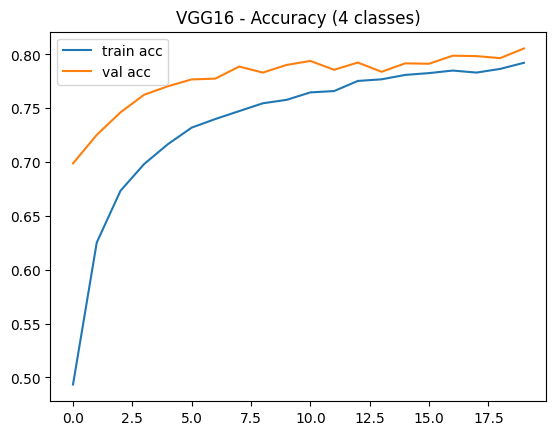

In [24]:
plt.plot(history_vgg_4c.history["accuracy"], label="train acc")
plt.plot(history_vgg_4c.history["val_accuracy"], label="val acc")
plt.legend()
plt.title("VGG16 - Accuracy (4 classes)")
plt.show()


### Matrice de confusion

84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step


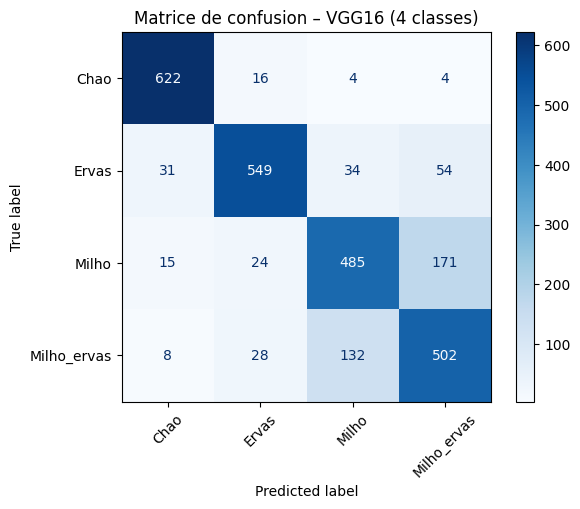

In [25]:
y_true = val_gen_vgg.classes
y_pred = np.argmax(model_vgg_4c.predict(val_gen_vgg), axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    cm, display_labels=val_gen_vgg.class_indices.keys()
)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matrice de confusion – VGG16 (4 classes)")
plt.show()


## 9. Explicabilité des prédictions avec LIME

Afin de mieux comprendre les décisions prises par le modèle de classification d’images, nous utilisons la méthode LIME (Local Interpretable Model-agnostic Explanations). Cette approche permet d’identifier les régions de l’image qui contribuent le plus à la prédiction effectuée par le modèle.


In [27]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0e250e80546f10fa564319c6cfe56b941690d1f3849664657f497dfa47eaf7c3
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [28]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [29]:
def predict_fn(images):
    images = np.array(images)
    images = preprocess_input(images)
    return model_vgg_4c.predict(images)

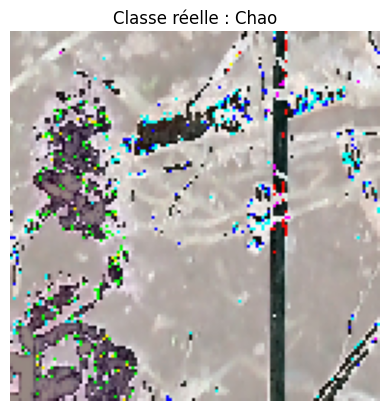

In [30]:
# Récupérer une image du jeu de validation
val_images, val_labels = next(val_gen_vgg)

image = val_images[0]
true_label = np.argmax(val_labels[0])

plt.imshow(image.astype("uint8"))
plt.title(f"Classe réelle : {list(val_gen_vgg.class_indices.keys())[true_label]}")
plt.axis("off")
plt.show()

In [31]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image.astype("double"),
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━

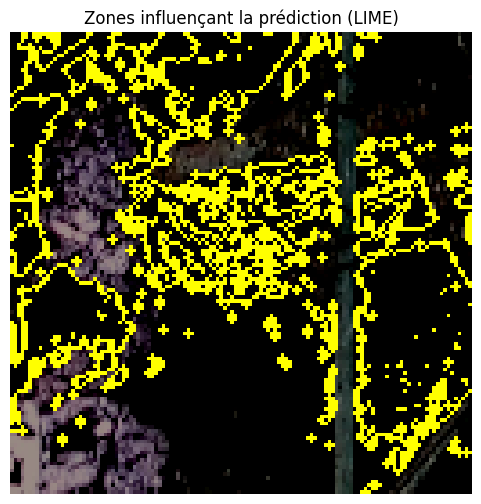

In [32]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("Zones influençant la prédiction (LIME)")
plt.axis("off")
plt.show()


In [33]:
preds = model_vgg_4c.predict(np.expand_dims(preprocess_input(image), axis=0))[0]

for cls, idx in val_gen_vgg.class_indices.items():
    print(f"{cls} : {preds[idx]*100:.2f} %")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Chao : 95.63 %
Ervas : 4.37 %
Milho : 0.00 %
Milho_ervas : 0.00 %


LIME permet de vérifier que le modèle ne base pas ses décisions sur des éléments parasites, comme le sol ou l’arrière-plan, mais bien sur les zones de végétation pertinentes pour la classification.